# Mini Grid Optimiser
Tool designed to take a small village and estimate the optimum connections, based on a PV installation location and economic data.

### Enter all input data here

In [1]:
input_file = "shp/OSM_Nakiu_buildings.shp"
minimum_area_m2 = 20 # exclude any buildings with area (in m2) below this value

demand_multiplier = 1 # the expected income in USD/year as a multiplier of a house's roof size
price_pv_multiplier = 0.25 # as a multiplier of the total roof area of the village (after filtering)
price_wire = 10 # per metre
price_conn = 100 # per node
price_maintenance = 0.02 # 2% of the above per year
years = 10 # years over which to amortize (and maintain)
max_tot_length = 10000000 # The furthest a single building can be (in total) from the PV point

output_file_buildings = "shp/Nakiu_buildings_connected.shp"
output_file_network = "shp/Nakiu_network_calculated.shp"
output_file_pv = "shp/Nakiu_pv_point.shp"

### Then we do all the necessary Python imports

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroML.clustering import HierarchicalClustering, get_graph_segments
from shapely.geometry import Point, LineString
from math import sqrt
from IPython.display import display, Markdown
import folium
import geopandas as gpd

In [3]:
buildings = gpd.read_file(input_file)
buildings_projected = buildings.copy()
# This is the Africa Albers Equal Area Conic EPSG: 102022
epsg102022 = '+proj=aea +lat_1=20 +lat_2=-23 +lat_0=0 +lon_0=25 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
buildings_projected = buildings_projected.to_crs(epsg102022)

buildings_projected["area_m2"] = buildings_projected['geometry'].area
buildings_points = buildings_projected.copy()
buildings_points.geometry = buildings_points['geometry'].centroid
buildings_points['X'] = buildings_points.geometry.x
buildings_points['Y'] = buildings_points.geometry.y

### Here we display a map of the selected village.

In [4]:
x_mean = buildings.geometry.centroid.x.mean()
y_mean = buildings.geometry.centroid.y.mean()
village_map = folium.Map([y_mean, x_mean], zoom_start=15)
folium.ClickForMarker().add_to(village_map)
display(Markdown('### Please click on the desired location for the PV point.'))
display(Markdown('### Then click on the marker that appears and copy the values in below (with all decimals values!).'))
display(village_map)

### Please click on the desired location for the PV point.

### Then click on the marker that appears and copy the values in below (with all decimals values!).

### Enter the values here:

In [5]:
latitude = -9.6297
longitude = 39.1873

### We then take all the houses and calculate the optimum network that connects them all to the PV point, before we start analysing further and deciding on the optimum network.

### A small graph is shown below, with the PV point in green

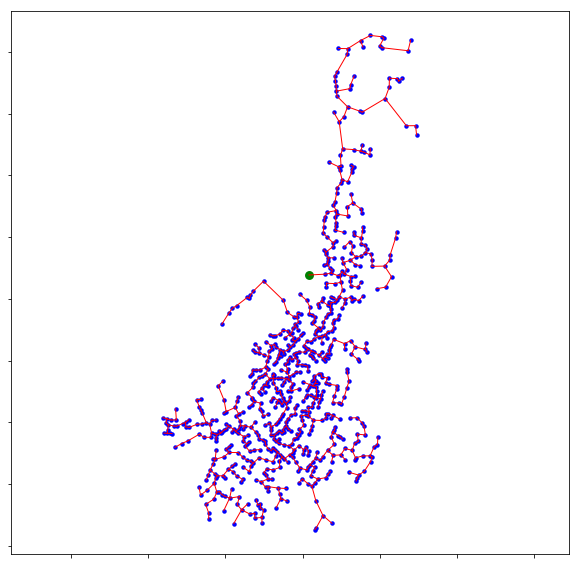

In [6]:
df = pd.DataFrame(buildings_points)
df = df.loc[df['area_m2'] > minimum_area_m2]

pv_point = gpd.GeoDataFrame(crs={'init': 'epsg:4326'}, geometry=[Point([longitude, latitude])])
pv_point_projected = pv_point.copy()
pv_point_projected = pv_point_projected.to_crs(epsg102022)
pv_point_df = [{'X': pv_point_projected.geometry.x, 'Y': pv_point_projected.geometry.y, 'area_m2': 0}]
df = pd.concat([pd.DataFrame(pv_point_df), df], ignore_index=True)
points = df[['X', 'Y']].as_matrix()

model = HierarchicalClustering(n_neighbors=10, edge_cutoff=0.9, min_cluster_size=10)
model.fit(points)
T_x, T_y = get_graph_segments(model.X_train_, model.full_tree_)

fig = plt.figure(figsize=(10, 10))
plt.scatter(points[1:, 0], points[1:, 1], s=20, lw=0, c='blue')
plt.scatter(points[:1, 0], points[:1, 1], s=80, lw=0, c='green')
plt.plot(T_x, T_y, c='red', lw=1)
display(Markdown('### A small graph is shown below, with the PV point in green'))

fig.axes[0].tick_params(labelbottom='off', labelleft='off')
plt.axis('equal')
plt.show()

### This point and line data is then copied into two arrays, called *nodes* and *network_undirected*, containing the houses and lines, respectively. Each element represents a single house or joining arc, and has data within describing the coordinates and more.

In [7]:
# Structure for network:
# 0   index
# 1   xs
# 2   ys
# 3   xe
# 4   ye
# 5   node index first point
# 6   node index last point
# 7   whether this arc is directed (0 or 1)
# 8   arc length
# 9   whether enabled (default to 1)

# Structure for nodes:
# The PV point is indexed at point 0
# 0   index
# 1   x
# 2   y
# 3   income
# 4   marginal distance
# 5   total distance
# 6   connected (default to 0)
# 7.. connected arc indices

# astype(int) doesn't round - it just chops off the decimals

df['income'] = df['area_m2'].astype(int) * demand_multiplier
nodes = df[['X', 'Y', 'income']].reset_index().values.astype(int).tolist()
for node in nodes:
    # add default 0's for marg_dist, tot_dist and connected
    node.extend([0, 0, 0])
    

counter = 0
network_undirected = []
for xs, ys, xe, ye in zip(T_x[0], T_y[0], T_x[1], T_y[1]):
    network_undirected.append([counter, int(xs), int(ys), int(xe), int(ye), -99, -99, 0, 0, 1])
    counter += 1
    
# add the length for each arc
for arc in network_undirected:
    arc[8] = sqrt((arc[3] - arc[1])**2 + (arc[4] - arc[2])**2)

### Then we need to calculate the directionality of the network, starting from the PV location and reaching outwards to the furthest branches. We use this to calculate, for each node, it's marginal and total distance from the PV location.
At the same time, we tell each arc which node is 'upstream' of it, and which is 'downstream'. We also tell each node which arcs (at least one, up to three or four?) it is connected to.

In [8]:
def direct_network(nodes, network, index):
    for arc in network:
        found = False
        if arc[1] == nodes[index][1] and arc[2] == nodes[index][2]:
            # make sure we haven't done this arc already!
            if arc[7] == 1:
                continue
            found = True
            
        elif arc[3] == nodes[index][1] and arc[4] == nodes[index][2]:
            # make sure we haven't done this arc already!
            if arc[7] == 1:
                continue
            found = True
            
            # flip it around because it's pointing the wrong way
            xs_new = arc[3]
            ys_new = arc[4]
            arc[3] = arc[1]
            arc[4] = arc[2]
            arc[1] = xs_new
            arc[2] = ys_new
            
        if found:    
            arc[5] = nodes[index][0] # tell this arc that this node is its starting point
            arc[7] = 1 # so we know this arc has been done
            arc_index = arc[0] # store arc index to find point at the other end
            
            for node in nodes:
                if node[1] == arc[3] and node[2] == arc[4]:
                    arc[6] = node[0] # tell this arc that this node is its ending point
                    node[4] = arc[8] # assign arc length to node's marginal distance
                    node[5] = nodes[index][5] + arc[8] # and calculate total distance
                    
                    # If this building exceeds the maximum total length allowed, disable the arc connecting it
                    # The later algorithms respect this settings
                    if node[5] > max_tot_length:
                        arc[9] = 0
                    
                    nodes, network = direct_network(nodes, network, node[0]) # and investigate downstream from this node
                    break
    
    return nodes, network

# network_undirected seems to also be modified, which could be dangerous!

nodes, network_directed = direct_network(nodes, network_undirected, 0)

# for every node, add references to every arc that connects to it
for arc in network_directed:
    nodes[arc[5]].append(arc[0])
    nodes[arc[6]].append(arc[0])

### Here we prepare the algorithm to optimise our network configuration, by pruning network extensions that aren't profitable. Here the economic data should be entered.

In [9]:
# optimisation strategy #2
# cut arcs one by one, see which cut is the *most* profitable, and then take that network and repeat the process
# annual income should be specified by the nodes

def calculate_profit(nodes, network, index, disabled_arc_index, cost, income):
    # here we recurse through the network and calculate profit
    # start with all arcs that connect to the index node, and get the end-nodes for those arcs
    # calculate profit on those nodes, and then recurse!
    # disabled_arc should be treated as if disabled
    
    # first calculate tehe profitability of thise node?
    cost += price_wire * nodes[index][4] + price_conn
    income += nodes[index][3]
    
    connected_arcs = [network[arc_index] for arc_index in nodes[index][7:]]
    for arc in connected_arcs:
        if arc[9] == 1 and arc[0] != disabled_arc_index and arc[5] == index:
            cost, income, nodes, network = calculate_profit(nodes, network, arc[6], disabled_arc_index, cost, income)
            
    return cost, income, nodes, network

### Then we start with the complete network, and try 'deleting' each arc. Whichever deletion is the most profitable, we make it permanent and repeat the process with the new configuration. This continues until there are no more increases in profitability to be had.

In [10]:
price_pv = df['area_m2'].sum() * price_pv_multiplier

most_profitable = -9999999
handle = display(Markdown(f'Most profitable: {most_profitable}'), display_id=True)
while True:
    handle.update(Markdown(f'Most profitable: ${most_profitable:.0f}'))
    found = False
    for arc in network_directed:
        # use a recursive function to calculate profitability of network
        # this should all be done in a temporary network variable
        # and indicate that this arc should be treated as if disabled
        cost, income, nodes, network = calculate_profit(nodes, network_directed, 0, arc[0], 0, 0)

        capex = price_pv + cost
        opex = (price_maintenance * capex) * years
        total_income = income * years
        profit = total_income - capex - opex
        
        # check if this is the most profitableb yet
        if profit > most_profitable:
            found = True
            most_profitable = profit
            most_profitable_index = arc[0]
    if found:
        # disable that arc
        network_directed[most_profitable_index][9] = 0

    # now repeat the above steps for the whole network again
    # until we go through without finding a more profitable setup than what we already have
    else:
        break

Most profitable: $136836

### Then we disconnect all the houses that are no longer served by active arcs, and prune any stranded arcs that remained on un-connected paths.

In [11]:
# now we need to tell the houses that aren't connected, that they aren't connected (or vice-versa)
# recurse from the starting point and ID connected houses as connected?
def connect_houses(nodes, network, index):
    # start from base, follow connection (similar to calculate_profit) and swith node[6] to 1 wherever connected
    # and only follow the paths of connected houses
    
    # this node is connected
    nodes[index][6] = 1
    
    connected_arcs = [network[arc_index] for arc_index in nodes[index][7:]]
    for arc in connected_arcs:
        if arc[9] == 1 and arc[5] == index:
            connect_houses(nodes, network, arc[6])
            
    return nodes, network
    
nodes, network_directed = connect_houses(nodes, network_directed, 0)

# and do the same for the stranded arcs
for node in nodes:
    if node[6] == 0:
        connected_arcs = [network[arc_index] for arc_index in node[7:]]
        for arc in connected_arcs:
            arc[9] = 0

### And calculate some quick summary numbers for the village

In [12]:
# create a quick report
# number connected, length of line, total profit over ten years
count_nodes = 0
income = 0
for node in nodes:
    if node[6] == 1:
        count_nodes += 1
        income += node[3]

total_length = 0.0
total_potential_length = 0.0
for arc in network_directed:
    if arc[9] == 1:
        total_length += arc[8]
    total_potential_length += arc[8]

capex = price_pv + price_conn * count_nodes + total_length * price_wire
opex = (price_maintenance * capex) * years
total_income = income * years

### And then do a spatial join to get the results back into a polygon shapefile

In [13]:
# join the resultant points with the orignal buildings_projected
nodes_for_df = [node[0:7] for node in nodes]
nodes_df = pd.DataFrame(columns=['idx', 'X', 'Y', 'income', 'marg_dist', 'tot_dist',
                                  'connected'], data=nodes_for_df)
nodes_geometry = [Point(xy) for xy in zip(nodes_df['X'], nodes_df['Y'])]
nodes_gdf = gpd.GeoDataFrame(nodes_df, crs=buildings_projected.crs, geometry=nodes_geometry)

network_df = pd.DataFrame(columns=['idx', 'xs', 'ys', 'xe', 'ye', 'node_start', 'node_end',
                                   'directed', 'length', 'enabled'], data=network)
LineString([(arc[1], arc[2]), (arc[3], arc[4])])
network_geometry = [LineString([(arc[1], arc[2]), (arc[3], arc[4])]) for arc in network]
network_gdf = gpd.GeoDataFrame(network_df, crs=buildings_projected.crs, geometry=network_geometry)

buildings_joined = gpd.sjoin(buildings_projected, nodes_gdf)

### Before mapping the results and saving the output into two shapefiles!

In [14]:
# project back to an unprojected (i.e., in degrees) CRS
network_wgs84 = network_gdf.copy()
network_wgs84 = network_wgs84.to_crs(epsg=4326)
network_wgs84 = network_wgs84.loc[network_wgs84['enabled'] == 1]

buildings_wgs84 = buildings_joined.copy()
buildings_wgs84 = buildings_wgs84.to_crs(epsg=4326)
buildings_wgs84 = buildings_wgs84.loc[buildings_wgs84['connected'] == 1]

nodes_wgs84 = nodes_gdf.copy()
nodes_wgs84 = nodes_wgs84.to_crs(epsg=4326)
nodes_wgs84 = nodes_wgs84.loc[nodes_wgs84['connected'] == 1]

village_map = folium.Map([y_mean, x_mean], zoom_start=15)

for index, row in network_wgs84.iterrows():
    # Can't use row.geometry.coords because Folium interprets X and Y the other way around, for whatever reason
    coords = list(row.geometry.coords)
    xs = coords[0][0]
    ys = coords[0][1]
    xe = coords[1][0]
    ye = coords[1][1]
    folium.PolyLine([(ys, xs), (ye, xe)]).add_to(village_map)

folium.Marker([latitude, longitude]).add_to(village_map)
    
"""    
for index, row in nodes_wgs84.iterrows():
    # Can't use row.geometry.coords directly because Folium interprets X and Y the other way around, for whatever reason
    coords = list(row.geometry.coords)
    x = coords[0][0]
    y = coords[0][1]
    folium.Marker([y, x]).add_to(village_map)
"""

display(Markdown(f'Total houses connected: {count_nodes} out of {len(nodes)-1}'))
display(Markdown(f'Total length of lines is {total_length:.0f}m'))
display(Markdown(f'CAPEX: ${capex:.0f}'))
display(Markdown(f'OPEX: ${opex:.0f}'))
display(Markdown(f'Income: ${total_income:.0f}'))
display(Markdown(f'**Total profit over {years} years is ${most_profitable:.0f}**'))
display(village_map)

buildings_wgs84.to_file(output_file_buildings)
network_wgs84.to_file(output_file_network)
pv_point.to_file(output_file_pv)

Total houses connected: 651 out of 734

Total length of lines is 10653m

CAPEX: $181278

OPEX: $36256

Income: $354370

**Total profit over 10 years is $136836**